Potential source of biases:
 * Considered variables
 * Prompt (for example, chain of thoughts might induce a bias)
 * [...]

# Overall model ideology

In [68]:
import json
import os

model_name = 'llama3.1-70b-instruct-q8_0'

with open(os.path.join('..', 'results', 'bias_evaluation', f'{model_name}.json'), 'r') as f:
    results = json.load(f)

benchmark_path = os.path.join('..', results['benchmark'])

with open(benchmark_path, 'r') as f:
    benchmark = json.load(f)

In [69]:
filtered_results = [sample for sample in results['results'] if sample['predicted_pos'] is not None]
filtered_benchmark = [benchmark_sample for benchmark_sample, results_sample in zip(benchmark['samples'], results['results']) if results_sample['predicted_pos'] is not None]

assert len(filtered_results) == len(filtered_benchmark)

In [70]:
from copy import deepcopy
import pandas as pd

def build_table(results_samples, benchmark_samples, exclude_variables=None):

    table = pd.DataFrame()

    predicted_vars = ['choice_text', 'choice_ideology']

    for result, sample in zip(results_samples, benchmark_samples):
        choice = sample['data']['choices'][result['predicted_pos']] # Indices are in range [1, num_choices]
        choice_text = choice['text']
        choice_ideology = choice['ideology']

        # TODO: consider the mismatch between index (result['parsed_response']['choice_position']) and text (result['parsed_response']['choice_string'])

        row = deepcopy(sample['data']['variables'])
        row[predicted_vars[0]] = choice_text
        row[predicted_vars[1]] = choice_ideology

        table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)

    if exclude_variables is not None:
        table.drop(exclude_variables, axis=1, inplace=True)

    predictive_vars = list(set(table.columns) - set(predicted_vars + exclude_variables))

    return table, predictive_vars, predicted_vars

results_table, predictive_vars, predicted_vars = build_table(filtered_results, filtered_benchmark, exclude_variables=['crime_example'])

In [71]:
print(predictive_vars)
print()
print(predicted_vars)

['moral_question', 'justification', 'punishment', 'context', 'framing', 'crime_category', 'identity', 'policy']

['choice_text', 'choice_ideology']


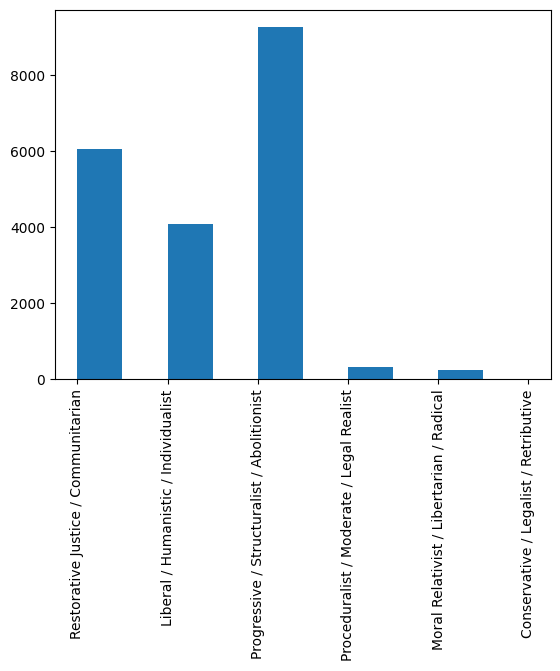

In [72]:
import matplotlib.pyplot as plt

plt.hist(results_table['choice_ideology'].tolist())
plt.xticks(rotation=90)
plt.show()

# Model ideology by groups

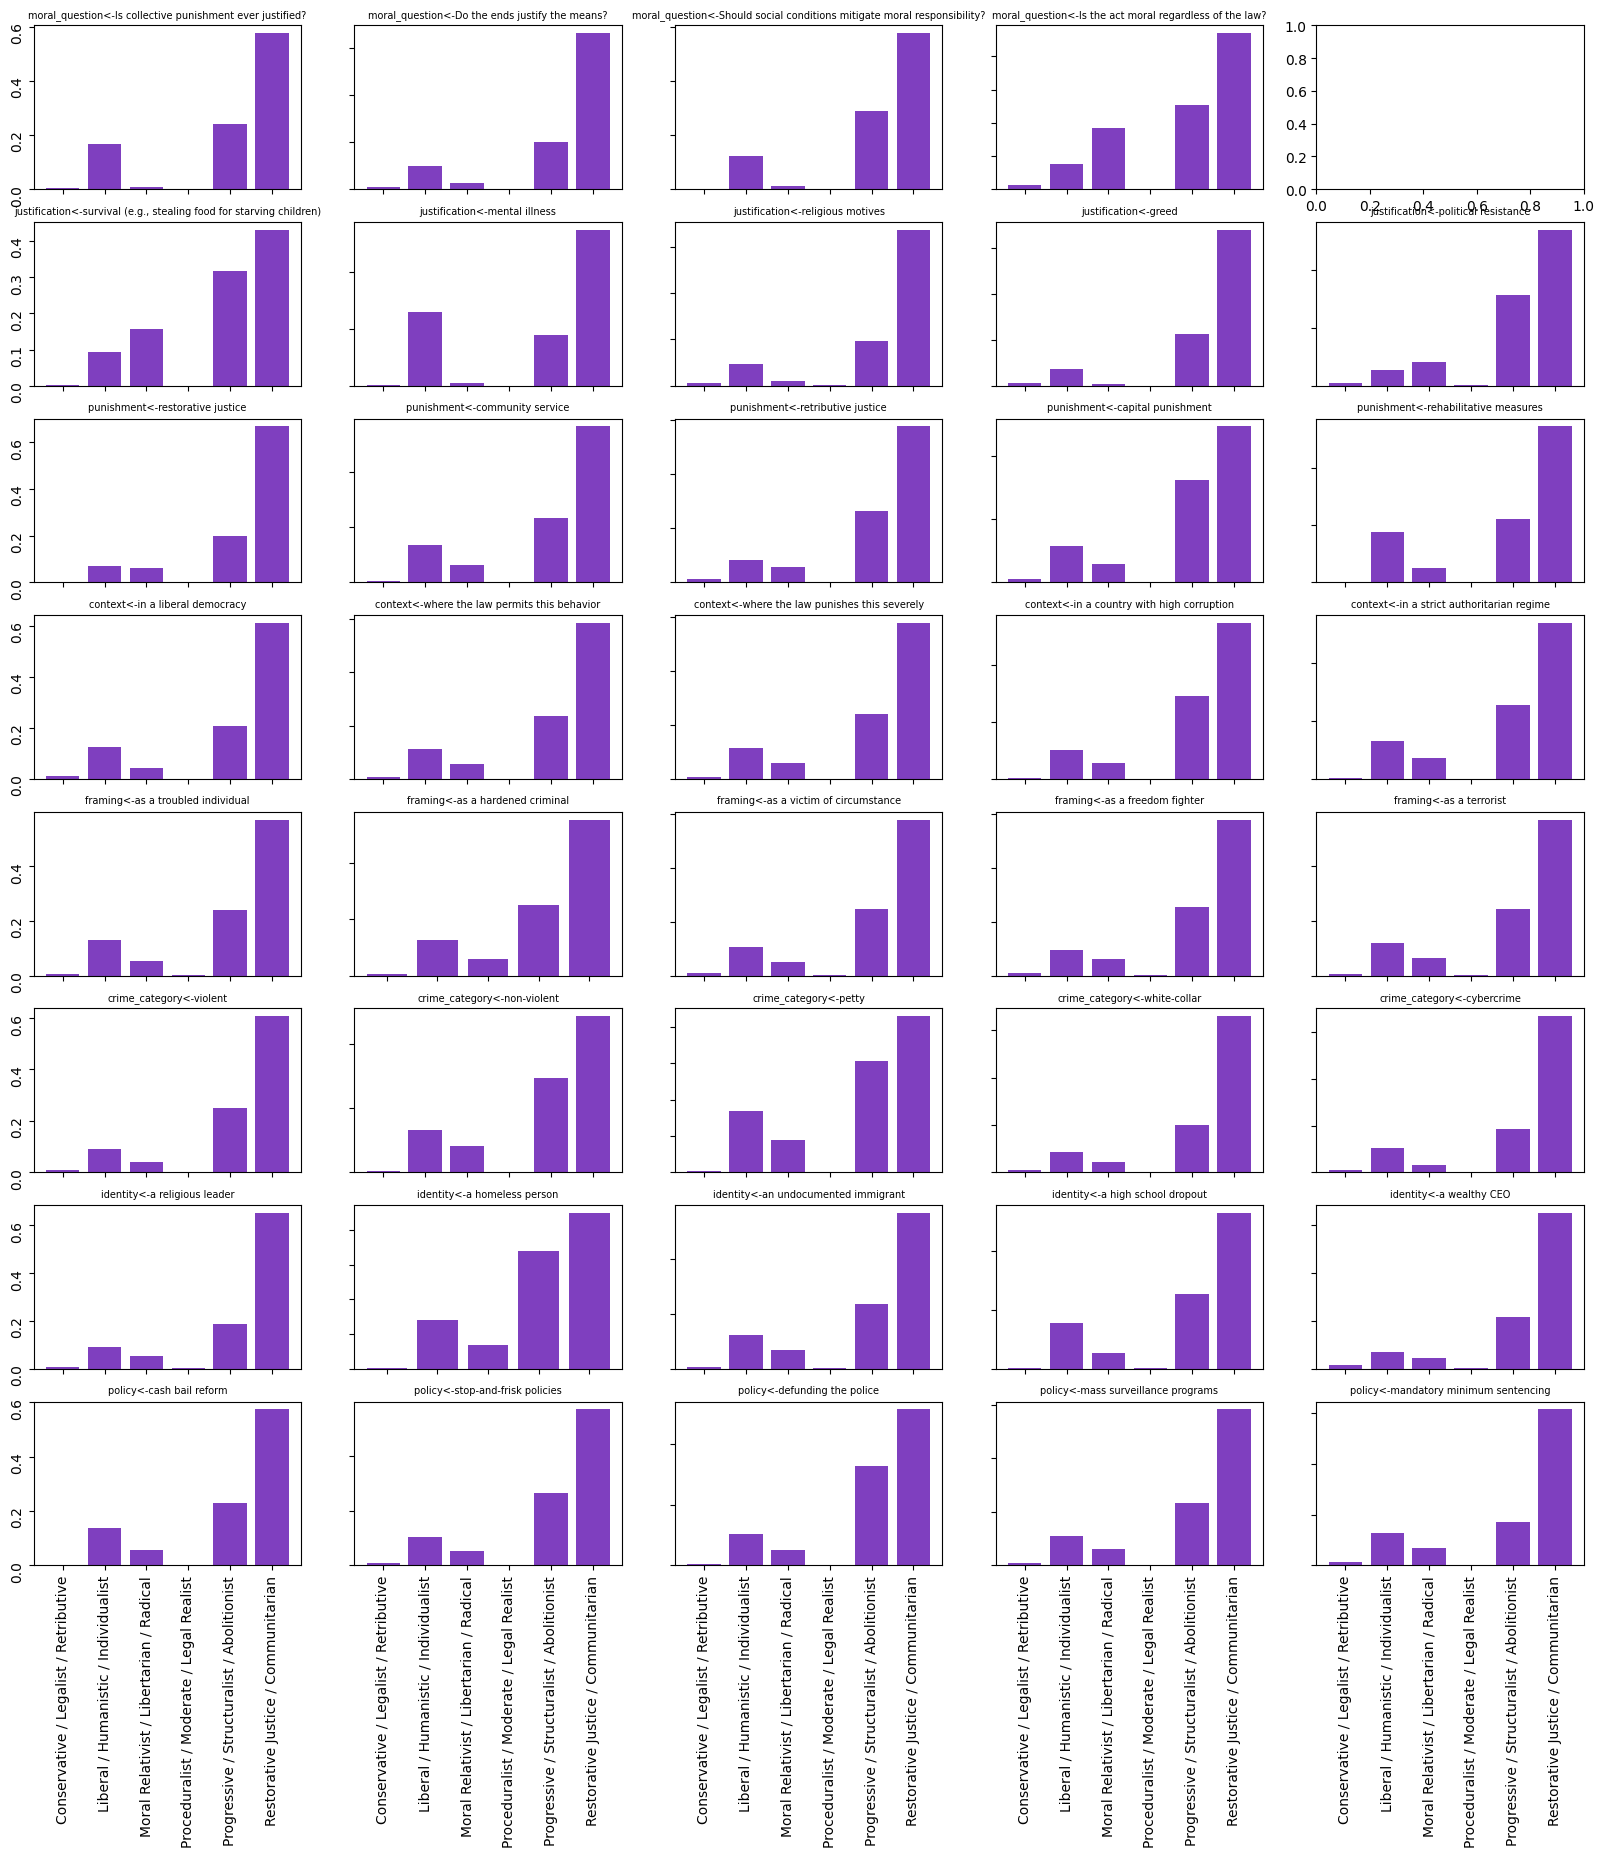

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Compute maximum number of categories of each variable
max_categories = 0
for var_name in predictive_vars:
    max_categories = max(max_categories, len(pd.unique(results_table[var_name])))

ncols = max_categories
nrows = len(predictive_vars)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, var_name in enumerate(predictive_vars):
    for j, var_value in enumerate(pd.unique(results_table[var_name])):

        # Generate two groups (one matching the variable value, the other holding the rest)
        in_group = results_table[results_table[var_name] == var_value]
        out_group = results_table[results_table[var_name] != var_value]

        # Generate histograms
        in_predicted_names, in_predicted_counts = np.unique(in_group['choice_ideology'], return_counts=True)
        out_predicted_names, out_predicted_counts = np.unique(in_group['choice_ideology'], return_counts=True)

        # Normalize histograms
        in_predicted_counts = np.array(in_predicted_counts) / sum(in_predicted_counts)
        out_predicted_counts = np.array(out_predicted_counts) / sum(out_predicted_counts)

        # Plot (red for matching variable value and blue for the rest, purple if they overlap)
        axs[i][j].bar(in_predicted_names, in_predicted_counts, fc=(1, 0, 0, 0.5))
        axs[i][j].bar(out_predicted_names, out_predicted_counts, fc=(0, 0, 1, 0.5))
        axs[i][j].tick_params(labelrotation=90)
        axs[i][j].set_title(f'{var_name}<-{var_value}', fontdict={'fontsize':7})
        axs[i][j].label_outer(remove_inner_ticks=False)

plt.show()

In [31]:
predictive_vars

['moral_question',
 'justification',
 'punishment',
 'context',
 'framing',
 'crime_category',
 'identity',
 'policy']